In [852]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import math
import time

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import LeaveOneOut

In [959]:
# Import and organize data. Use only FSR data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d1 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)

In [960]:
np.shape(data)

(72, 7000, 12)

In [1021]:
y = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [962]:
# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

In [963]:
# os_feature returns the maximum difference between peaks in the data, as well as the number of local maxima and
# minima in the given column

def max_min(col):
    length = np.size(col)
    D = np.array([0,col[0],0])
    for i in range(1,length-1):
        if ((col[i] > col[i-1]) and (col[i]>col[i+1])):
            D = np.vstack((D,[i, col[i],1]))
        if ((col[i]<col[i-1]) and (col[i]<col[i+1])):
            D = np.vstack((D,[i, col[i],0]))
    #plt.plot(D[:,0],D[:,1],'o')
    return D

def pseudo_jerk(array):
    jerk = 0
    length, _ = np.shape(array)
    time = array[:,0]
    force = array[:,1]
    for i in range(length-1):
        dtime = time[i+1]-time[i]
        dforce = abs(force[i+1]-force[i])
        new_jerk = dforce/dtime
        if new_jerk < jerk:
            jerk = new_jerk
    return jerk

def oscillation(col):
    #col = max_min(col)
    def maxima(col):
        length, _ = np.shape(col)
        for i in reversed(range(length)):
            if col[i,2] == 0:
                col = np.delete(col, i, 0)
        #plt.plot(col[:,0],col[:,1],'o')
        return col

    def os_feature(col):
        max_diff = 0
        length, _ = np.shape(col)
        for i in range(length-1):
            if (col[i+1,0]-col[i,0])>max_diff:
                 max_diff = col[i+1,0]-col[i,0]
        return max_diff, length
    return os_feature(maxima(col))

In [964]:
# Total impulse over the column of data. More to come, obviously

def impulse(col):
    return 0

In [965]:
# Maximum jerk over column, normalized to time
# Idea: pseudo-jerk in oscillation frequency function. i.e. take max change in acceleration between points

def jerk(col):
    max_jerk = 0
    length = np.size(col)
    for i in range(length-1):
        jerk_norm = abs(col[i]-col[i-1])
        if jerk_norm < max_jerk:
            max_jerk = jerk_norm
    return max_jerk

In [966]:
# This function takes all 72 data points of size (7001,16) and puts them into feature-engineered array (all features).
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 7
    featured_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
            max_diff, os_length = oscillation(max_min(column))
            D[5,i] = max_diff
            D[6,i] = os_length
            # D[0,i] = jerk(col)
            # D[0,i] = pseudo_jerk(max_min(col))
        featured_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return featured_data

In [967]:
# Condense data into averages over a specified number of data points

def condense(array, condense_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
    return condensed_data

In [968]:
# Condense data by small factor (10)
data = condense(data,10)
data2 = data/np.max(data)

# Normalize and feature-ify the data
normalized_data = data/np.max(data)
normalized_featured_data = features(normalized_data,.8)
np.shape(normalized_featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

(72, 7, 12)

In [938]:
# Turn 3D array into 2D array

def two_d(data):
    len_data, num_cols, num_points = np.shape(data)
    data_new = np.zeros((len_data, num_cols*num_points))
    for i in range(len_data):
        current = data[i]
        for j in range(num_cols):
            for k in range(num_points):
                data_new[i][num_points*j+k] = current[j][k]
    return data_new

In [871]:
def add_probs(array):
    new_probs = np.zeros((4, 4))
    for i in [0,2,4,6]:
        ind=np.int(i/2)
        for j in range(4):
            new_probs[ind][j] = array[i][j]+array[i+1][j]
    new_probs=np.transpose(new_probs)*100
    return new_probs/2

In [898]:
def train_xvalidation(data, num_train, num_est):
    
    # Split data into train, validation, and testing sets
    x = two_d(data)
    x_train, y_train = x[:num_train], y[:num_train]
    x_valid, y_valid = x[num_train:64], y[num_train:64]
    x_train_valid, y_train_valid = x[:64], y[:64]
    x_test, y_test = x[64:], y[64:]
    
    # Train uncalibrated random forest classifier on both train and validation data, evaluate on test data
    clf = RandomForestClassifier(n_estimators=num_est)
    clf.fit(x_train_valid, y_train_valid)
    clf_probs1 = clf.predict_proba(x_test)
    score = log_loss(y_test, clf_probs1)
    
    # Train random forest classifier, calibrate on validation data and evaluate on test data
    clf = RandomForestClassifier(n_estimators=num_est)
    clf.fit(x_train, y_train)
    clf_probs2 = clf.predict_proba(x_test)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(x_valid, y_valid)
    sig_clf_probs = sig_clf.predict_proba(x_test)
    sig_score = log_loss(y_test, sig_clf_probs)
    
    # Average probabilities
    clf_probs1 = add_probs(clf_probs1)
    clf_probs2 = add_probs(clf_probs2)
    sig_clf_probs = add_probs(sig_clf_probs)
    
    return clf_probs1, sig_clf_probs, clf_probs2, score, sig_score

In [899]:
def generate_plot(probability_array, title):
    N = 4
    label0 = probability_array[0]
    label1 = probability_array[1]
    label2 = probability_array[2]
    label3 = probability_array[3]

 
    # The position of the bars on the x-axis
    r = [0,1,2,3]
 
    # Names of group and bar width
    names = ['label0','label1','label2','label3']
    barWidth = 1
    
    plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
    plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
    plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
    plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
    plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
    plt.xticks(r, names)
    plt.xlabel("true test value")
    plt.ylabel('Probability')
    plt.title(title)

In [990]:
# Compare normalized vs. non-normalized data with 100 estimators

clf_probs1,_,_,_,_ = train_xvalidation(data, 32, 20)
clf_probs2,_,_,_,_ = train_xvalidation(normalized_data, 32, 20)

In [991]:
clf_probs1

array([[47.5,  0. , 10. ,  0. ],
       [25. , 82.5, 22.5, 20. ],
       [10. , 17.5, 55. , 35. ],
       [17.5,  0. , 12.5, 45. ]])

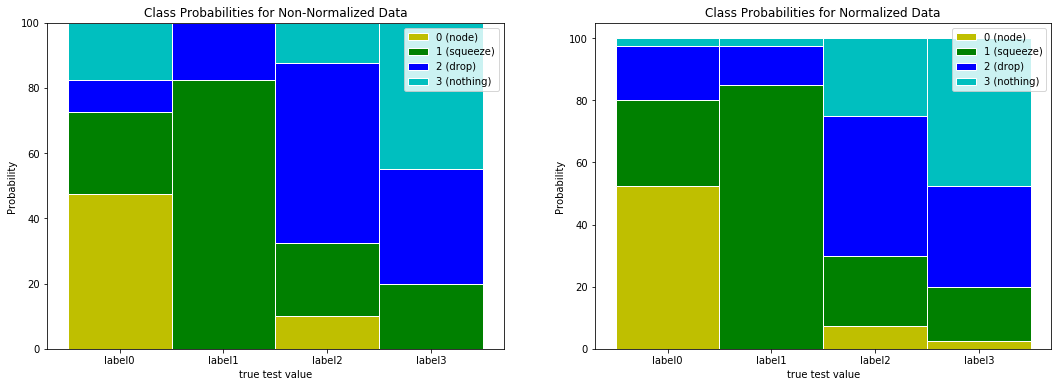

In [992]:
# Plot probabilities of normalized vs. non-normalized data

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities for Non-Normalized Data")
plt.subplot(1, 2, 2)
generate_plot(clf_probs2, "Class Probabilities for Normalized Data")

In [993]:
# Compare feature-ified vs. non-feature-ified data

# non-featured data
clf_probs1,_,_,_,_ = train_xvalidation(normalized_data, 32, 100)

# featured data
clf_probs2,_,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

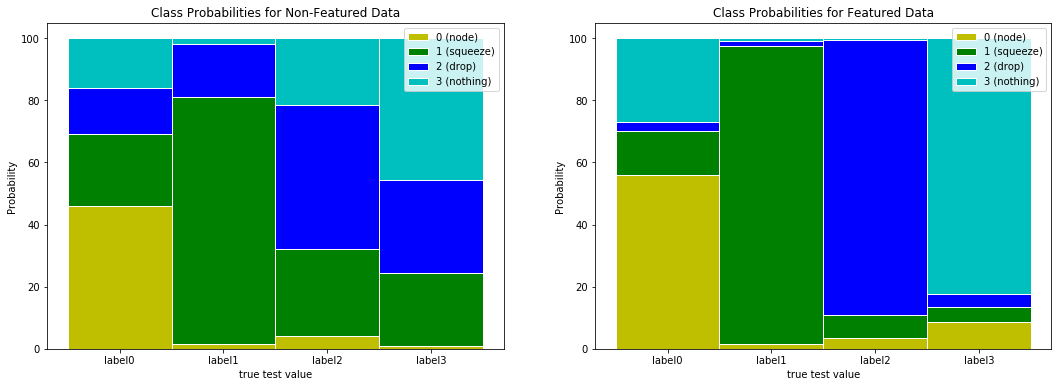

In [994]:
# Plot probabilities of non-featured vs. featured data

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities for Non-Featured Data")
plt.subplot(1, 2, 2)
generate_plot(clf_probs2, "Class Probabilities for Featured Data")

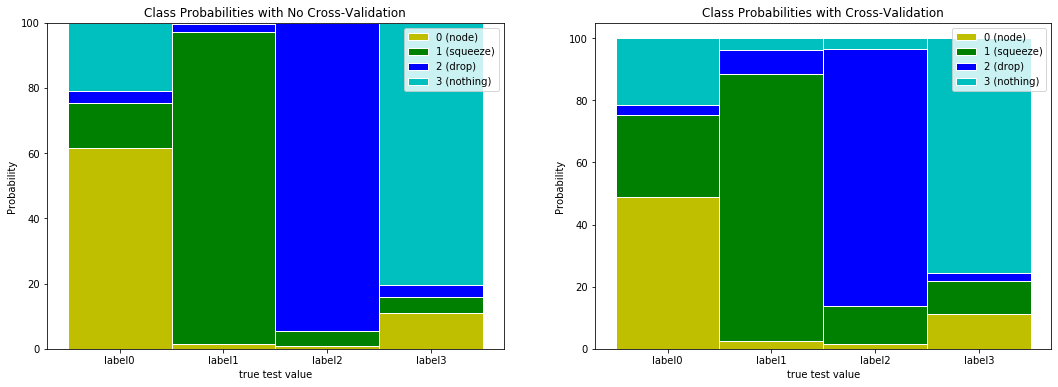

In [996]:
# Feature-engineered data: cross-validation vs. not
# This compares the classifier when trained on 64 data points and tested on the last 8 vs. when it is trained on 
# the first 32 data points, validated on the next 32 data points, and tested on the last 8

# Feature-engineered data. Get probabilities for uncalibrated classifier trained on both train and validation data
clf_probs1,_,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Feature-engineered data. Probabilities for random forest classifier calibrated on validation data and evaluated
# on test data
clf_probs2,sig_clf_probs,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Plot probabilities of cross-validation vs. no cross-validation

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities with No Cross-Validation")
plt.subplot(1, 2, 2)
generate_plot(sig_clf_probs, "Class Probabilities with Cross-Validation")

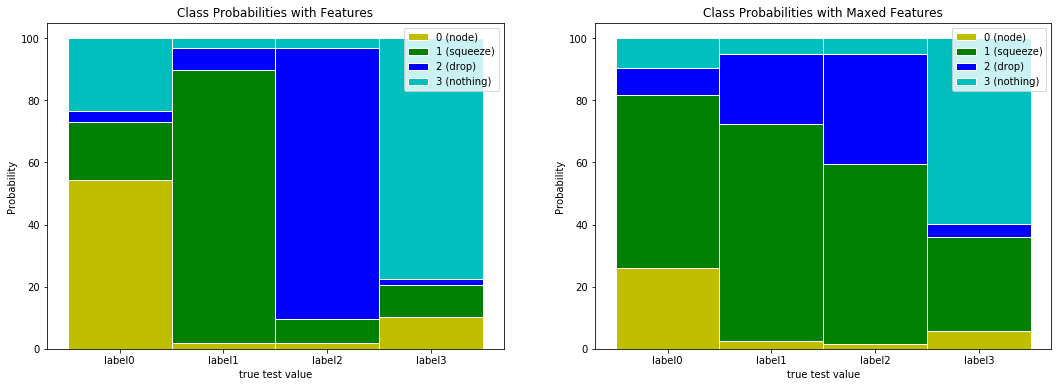

In [997]:
# Max features vs. all features

# Feature-engineered data. Get probabilities for uncalibrated classifier trained on both train and validation data
clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Feature-engineered data. Probabilities for random forest classifier calibrated on validation data and evaluated
# on test data
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(maxed_data, 32, 100)

# Plot probabilities of features vs. maxed features

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(sig_clf_probs1, "Class Probabilities with Features")
plt.subplot(1, 2, 2)
generate_plot(sig_clf_probs2, "Class Probabilities with Maxed Features")

In [1005]:
# Individual feature 

def one_feature(array, feature, three_quarters_percent=0):
    len_dataset, _, number_of_columns = np.shape(array)
    featured_data1 = np.zeros((len_dataset,1,12))
    featured_data2 = np.zeros((len_dataset,1,24))
    for j in range(len_dataset):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D1 = np.zeros((1,12),dtype=np.float64)
        D2 = np.zeros((1,24),dtype=np.float64)
        if feature == "max":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D1[0,i] = np.max(column)-np.min(column)
        if feature == "var":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D1[0,i] = np.var(column)
        if feature == "mean":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D1[0,i] = np.mean(column)
        if feature == "three quarters":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D1[0,i] = three_quarters(column, three_quarters_percent)
            if np.mod(j,6) == 0:
                print(j, end=" ")
        if feature == "sum":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D1[0,i] = np.sum(column)/np.max(column)
        if feature == "oscillation":
            for i in range(12):
                column = data_point[:,i]
                a,b = oscillation(max_min(column))
                D2[0,i] = a
                D2[0,i+12] = b
        if feature == "oscillation":
            featured_data2[j]=D2
        else:
            featured_data1[j]=D1
    if feature == "oscillation":
        return featured_data2
    else:
        return featured_data1

In [1006]:
mean_data = one_feature(normalized_data, "mean")
var_data = one_feature(normalized_data, "var")
os_data = one_feature(normalized_data, "oscillation")
three_quarters_data = one_feature(normalized_data, "three quarters", .75)
sum_data = one_feature(normalized_data, "sum")
os_data = one_feature(normalized_data, "oscillation")

0 6 12 18 24 30 36 42 48 54 60 66 

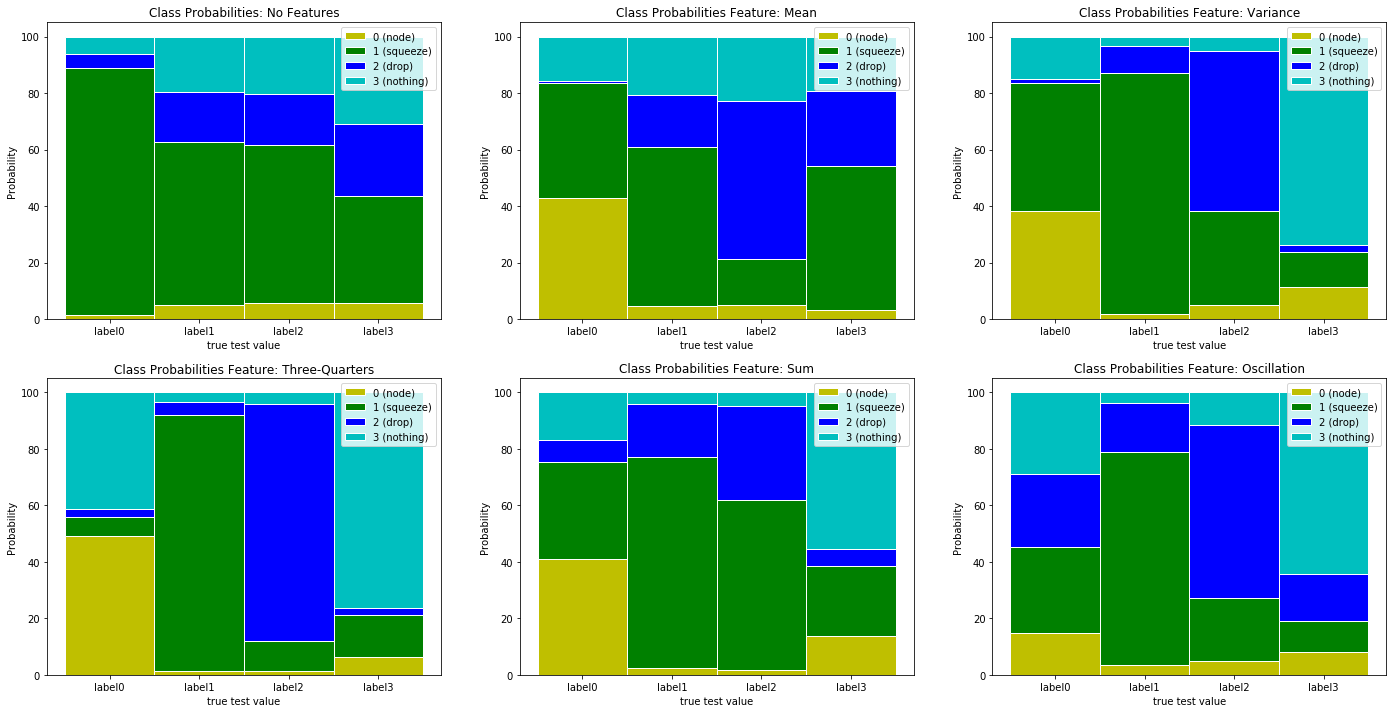

In [1009]:
# Feature Comparison, including Cross-Validation

# No features
clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(normalized_data, 32, 150)

# Feature: mean
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(mean_data, 32, 150)

# Feature: variance
clf_probs3,sig_clf_probs3,_,_,_ = train_xvalidation(var_data, 32, 150)

# Feature: three quarters (supposedly will distinguish drops from others) by finding out how many data points
# are less than or equal to 75% of the highest data point
clf_probs4,sig_clf_probs4,_,_,_ = train_xvalidation(three_quarters_data, 32, 150)

# Feature: sum
clf_probs5,sig_clf_probs5,_,_,_ = train_xvalidation(sum_data, 32, 150)

# Feature: oscillation
clf_probs6,sig_clf_probs6,_,_,_ = train_xvalidation(os_data, 32, 150)

# Plot probabilities of various features

fig= plt.figure(figsize=(24,12))
plt.title('Comparison of Features')
plt.subplot(2,3,1)
generate_plot(sig_clf_probs1, "Class Probabilities: No Features")
plt.subplot(2,3, 2)
generate_plot(sig_clf_probs2, "Class Probabilities Feature: Mean")
plt.subplot(2,3,3)
generate_plot(sig_clf_probs3, "Class Probabilities Feature: Variance")
plt.subplot(2,3,4)
generate_plot(sig_clf_probs4, "Class Probabilities Feature: Three-Quarters")
plt.subplot(2,3,5)
generate_plot(sig_clf_probs5, "Class Probabilities Feature: Sum")
plt.subplot(2,3,6)
generate_plot(sig_clf_probs6, "Class Probabilities Feature: Oscillation")

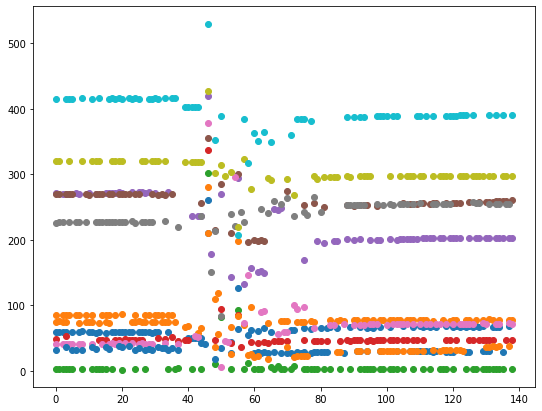

In [222]:
fig= plt.figure(figsize=(9,7))
for i in range(12):
    oscillation(condensed_data50[18][:,i])

In [42]:
X = normalized_data
loo = LeaveOneOut()
loo.get_n_splits(X)

72

In [43]:
y = np.asarray(y)

In [54]:
# Leave one out cross validation

for train_index, test_index in loo.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Test: {}".format(y[test_index]), "results: {}".format(y_test), end= "        ")

Test: [0] results: [0]        Test: [0] results: [0]        Test: [0] results: [0]        Test: [3] results: [3]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [3] results: [3]        Test: [0] results: [0]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [0] results: [0]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [1] 

In [1013]:
data = two_d(normalized_featured_data)
print(np.shape(data))
data = np.delete(data, 0, 1)


(72, 84)


In [1017]:
print(np.shape(x))

(71,)


In [1023]:
y = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [1122]:
y2=y
y2=np.reshape(y2,(1,-1))
print(np.shape(y2))
y2 = np.reshape(y2,(1,-1))
print(np.shape(y2))
print(np.array(y2[0,0:2]))

(1, 72)
(1, 72)
[0 0]


In [1129]:
def train_leave1out(data, num_train, num_est):
    
#     # Split data into train and testing sets
#     x = two_d(data)
#     x2, y2 = x, y
#     y2 = np.reshape(y2,(1,-1))
#     x_test, y_test = x2[num_train], y2[0,num_train]
#     #y_test = np.reshape(y_test,(1,-1))
#     x_test = np.reshape(x_test,(1,-1))
#     print(np.shape(x_test),np.shape(y_test))
#     x2 = np.delete(x2,num_train,0)
#     y2 = np.delete(y2,num_train,1)
#     y2 = np.reshape(y2,(71,1))
#     print(np.shape(x2), np.shape(y2))
#     x_train, y_train = x2, y2

# Split data into train, validation, and testing sets
#     x = two_d(data)
#     x2, y2 = x, y
#     y2 = np.reshape(y2,(1,-1))
#     x_test, y_test = x2[num_train:num_train+2], y2[0,num_train:num_train+2]
#     print(np.shape(x_test),np.shape(y_test))
#     x2 = np.delete(x2,num_train,0)
#     x2 = np.delete(x2,num_train,0)
#     print(np.shape(x2))
#     y2 = np.delete(y2,num_train,1)
#     y2 = np.delete(y2,num_train,1)
#     y2 = np.reshape(y2,(70,))
#     print(np.shape(y2))
#     x_train, y_train = x2, y2

    x = two_d(data)
    x_train, y_train = x[:num_train], y[:num_train]
    x_valid, y_valid = x[num_train:64], y[num_train:64]
    x_train_valid, y_train_valid = x[:64], y[:64]
    print(np.shape(x_train_valid),np.shape(y_train_valid))
    x_test, y_test = x[64:], y[64:]
    print(np.shape(x_test),np.shape(y_test))

#     x = two_d(data)
#     x_train, y_train = x[:num_train], y[:num_train]
#     x_valid, y_valid = x[num_train:64], y[num_train:64]
#     x_train_valid, y_train_valid = x[:64], y[:64]
#     x_test, y_test = x[num_train:num_train+2], y[num_train:num_train+2]
    
    # Train uncalibrated random forest classifier on train data, evaluate on test data
    clf = RandomForestClassifier(n_estimators=num_est)
    clf.fit(x_train, y_train)
    clf_probs1 = clf.predict_proba(x_test)
    score = log_loss(y_test, clf_probs1)
    print(clf_probs1)
    # Train random forest classifier, calibrate on validation data and evaluate on test data
#     clf = RandomForestClassifier(n_estimators=num_est)
#     clf.fit(x_train, y_train)
#     clf_probs2 = clf.predict_proba(x_test)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
#     sig_clf.fit(x_valid, y_valid)
#     sig_clf_probs = sig_clf.predict_proba(x_test)
#     sig_score = log_loss(y_test, sig_clf_probs)
    
    # Average probabilities
    clf_probs1 = add_probs(clf_probs1)
    #clf_probs2 = add_probs(clf_probs2)
    #sig_clf_probs = add_probs(sig_clf_probs)
    
    return clf_probs1, score

In [1132]:
i=4
num_train = i
clf_probs,_ = train_leave1out(normalized_featured_data,i,20)
print("{}:{}".format(i, clf_probs))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



(64, 84) (64,)
(8, 84) (8,)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1132-5dc4656b60b0>", line 3, in <module>
    clf_probs,_ = train_leave1out(normalized_featured_data,i,20)
  File "<ipython-input-1129-907096383316>", line 50, in train_leave1out
    score = log_loss(y_test, clf_probs1)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 2287, in log_loss
    lb.classes_))
ValueError: y_true and y_pred contain different number of classes 4, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    st

ValueError: y_true and y_pred contain different number of classes 4, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3]

In [1031]:
clf_probs

array([[56.5,  1. ,  1.5, 12.5],
       [20.5, 92. ,  6.5,  8.5],
       [ 2. ,  7. , 90.5,  1.5],
       [21. ,  0. ,  1.5, 77.5]])

[355.0]
[322.5]
[316.6666666666667]
[330.0]
[327.0]
[319.1666666666667]
[319.2857142857143]
[326.25]
[321.1111111111111]
[316.5]


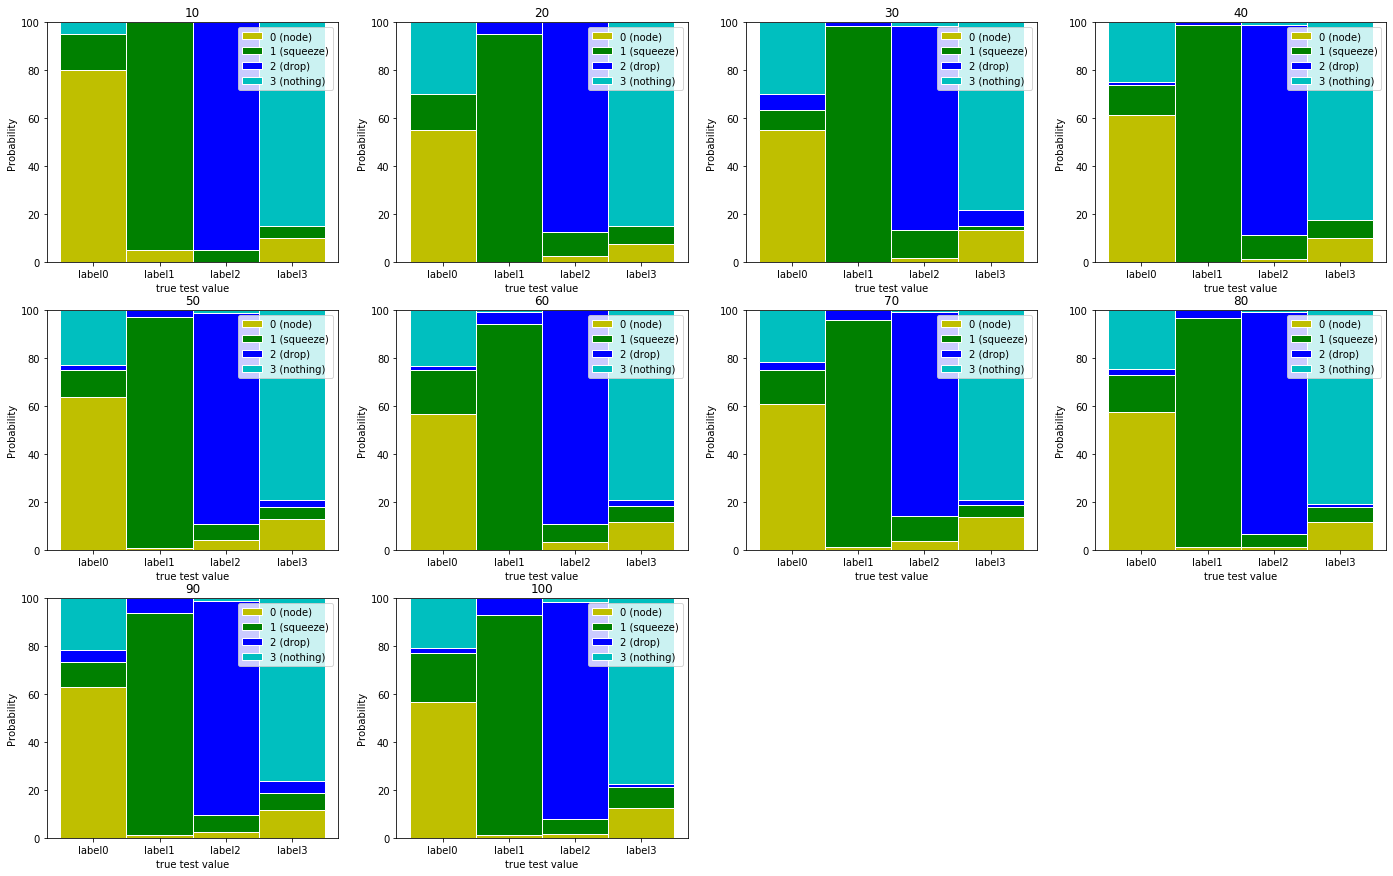

In [1019]:
fig= plt.figure(figsize=(24,15))

for i in range(10):
    clf_probs,_,_,_,_=train_xvalidation(normalized_featured_data,32,(i+1)*10)
    sum=0
    array=[]
    for j in range(4):
        sum += clf_probs[j,j]
        #print(sum)
    array.append(sum)
    print(array)
    plt.subplot(3,4,(i+1))
    generate_plot(clf_probs,"{}".format((i+1)*10))
        